# Twitter Sentiment Evaluator

#### MY NOTES and research

I started this project by doing all of the Deep NLP lessons at Flatiron in the appendix of Module 4
This included:
- Word embeddings
- Word2vec
- Sequence Models
- Recurrant Neural Networks (RNN)
- LSTM (Long Short term Membory) and GRU (Gated Recurrant Unit)

I also did some code along and lab with word classifiers.
RNN are good for time and sequenced classifications.  They can have vanishing and exploding gradient problems.  The modern equivalent to RNN is LSTM and GRU.  LSTM and GRU 'remember' and 'forget' data by feedback to the model throughout the sequence.  Gates keep only the most important info.  Neither is better, so you should try out both of them for these types of problems.  

Other notes:
We can train our own model, but there are ones out there that have been trained on all of wikipedia like GloVe which is what we will use here.  You can search for glove.6B.50d.txt to find the file.  It has all the weights and full dictionary of words.

It is best to set up pipelines so we can run multiple model types.  We can use traditional tree based, SVC, or logistic regression models.  

A Sequential NN with LSTM or GRU will likely work better for more complex tasks but will require more training and tuning time.

The input layer has to be a RNN type to deal with sequential data, then you can set up traditional NN (Dense, pooling, dropout etc)

### Project guidance
The Flatiron curriculum had this as an optional project, and that's why I'm trying it to build some skills.

Below is from the instructions:

If you choose this option, you'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

Your task is to:

Build a model that can rate the sentiment of a Tweet based on its content.

Aim for a Proof of Concept
There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.


#### Let's go!

In [286]:
import pandas as pd

import numpy as np
np.random.seed(0)

from nltk import word_tokenize
from gensim.models import word2vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [287]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv')
df = df.sample(frac=1)  # CHANGE ME TO ADJUST SIZE OF DATASET USED
df['emotion'] = df['is_there_an_emotion_directed_at_a_brand_or_product']
df = df.drop(columns=['is_there_an_emotion_directed_at_a_brand_or_product'])
print(len(df))
df.head()

9093


,tweet_text,emotion_in_tweet_is_directed_at,emotion
221,Just took a survey on iPhone while in Starbuck...,NaN,No emotion toward brand or product
7814,#blackberry users must feel like such losers h...,iPhone,Positive emotion
154,Anyone at #SXSW know if the apple store has ha...,NaN,No emotion toward brand or product
5742,RT @mention Free &quot;Payments on the #Androi...,NaN,No emotion toward brand or product
1220,Listening to folks around the world making iPh...,NaN,No emotion toward brand or product


Now, let's transform the dataset

In the cell below:

Store the column that will be the target, 'category', in the variable target
Use the 'tweet_text' column's .map() method to use the word_tokenize function on every piece of text
Store the .values attribute from the newly tokenized 'tweet_text' column in the variable data

In [288]:
df = df.dropna(subset=['emotion', 'tweet_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 221 to 2732
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       9092 non-null   object
 1   emotion_in_tweet_is_directed_at  3291 non-null   object
 2   emotion                          9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [289]:
target = df['emotion']
data = df['tweet_text'].map(word_tokenize).values

Loading A Pretrained GloVe Model


For this project, I will be loading the pretrained weights from GloVe (short for Global Vectors for Word Representation ) from the Stanford NLP Group. 

These are commonly accepted as some of the best pre-trained word vectors available, and they're open source, so you can get them for free! Even the smallest file is still over 800 MB, so you'll you need to download this file manually.

Note that there are several different sizes of pretrained word vectors available for download from the page linked above -- for the purposes of this lesson, you'll only need to use the smallest one, which still contains pretrained word vectors for over 6 billion words and phrases! To download this file, follow the link above and select the file called glove.6b.zip. For simplicity's sake, you can also start the download by clicking this link. You'll be using the GloVe file containing 50-dimensional word vectors for 6 billion words. Once you've downloaded the file, unzip it, and move the file glove.6B.50d.txt into the same directory as this Jupyter notebook.

Since this is a 'proof of concept' project, I will just do the smaller glove to save time.

Getting the Total Vocabulary
Although the pretrained GloVe data contains vectors for 6 billion words and phrases, you don't need all of them. Instead, you only need the vectors for the words that appear in the dataset. If a word or phrase doesn't appear in the dataset, then there's no reason to waste memory storing the vector for that word or phrase.

This means that you need to start by computing the total vocabulary of the dataset. You can do this by adding every word in the dataset into a Python set object. This is easy, since you've already tokenized each comment stored within data.

In the cell below, add every token from every comment in data into a set, and store the set in the variable total_vocabulary.

In [290]:
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))


There are 10665 unique words in the dataset.
There are 9092 unique tweets in the dataset.


### Extract Glove vectors
We will take only the relevant words that exist in our dataset and see how that works.

For testing, we will only use 20% of the dataset.  Later, if we have the resources, we will up that number.  Its in the first lines of code in this ipynb.

In [291]:
glove = {} # single dict to hold all of my words and vectors
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()  # go line by line and split to 
        word = parts[0].decode('utf-8')  # just pulls out the word, not the vectors
        if word in total_vocabulary:
            # if the word is in our dataset, we grab the vectors and put it in the glove dictionary
            vector = np.array(parts[1:], dtype=np.float32)  # everything past the word is the vector
            glove[word] = vector # add to dict

After running the cell above, you now have all of the words and their corresponding vocabulary stored within the dictionary, glove, as key/value pairs.

In [292]:
print(len(glove))  # not as many words as above, but maybe some hashtags or misspellings etc not in set (check later)
glove['worst'] # quick check.  I would assume worst will be in there when using reviews

7950


array([-0.14968  , -0.42252  ,  0.16736  ,  0.13474  , -0.31065  ,
       -0.11993  ,  0.041695 ,  0.32462  ,  0.15964  ,  0.063534 ,
       -0.55293  , -0.69798  , -0.88776  ,  0.1533   ,  1.4365   ,
       -0.51171  ,  0.21257  , -0.084376 , -1.078    ,  0.50821  ,
       -0.51022  , -0.27264  ,  0.2177   , -0.14752  ,  0.12493  ,
       -1.3302   , -1.0127   , -0.13035  ,  1.0936   ,  0.73769  ,
        2.7542   ,  0.47829  ,  0.62271  , -0.55323  , -0.2487   ,
        0.49747  , -0.25406  , -0.82531  ,  0.2355   , -0.31773  ,
       -2.0148   ,  0.0085579,  0.59227  , -0.22375  ,  0.097944 ,
        0.7723   , -0.19696  ,  0.45305  ,  0.58813  , -0.15727  ],
      dtype=float32)

### Create Mean Word Embeddings

For this step, we will set up pipelines from scikit-learn. Using pipelines will save us time and make the code a bit cleaner.

In [293]:
class W2vVectorizer(object):
    '''
    word vector object that we can use in pipeline
    '''
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

## Pipelines

Since we created a mean vectorizer class, you can pass this in as the first step in the pipeline, and then follow it up with the model you'll feed the data into for classification.

Run the cell below to create pipeline objects that make use of the mean embedding vectorizer that was built above.

In [294]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

Now, we create a list that contains a tuple for each pipeline, where the first item in the tuple is a name, and the second item in the list is the actual pipeline object.

In [295]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

Use the list created above, and cross_val_score() function from scikit-learn to train all the models, and store their cross validation scores in an array.

In [296]:
#  This cell may take a while to run depending on set size
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
/Users/aaronlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative so

In [297]:
print(scores)
df.emotion.unique()

[('Random Forest', 0.6188957325120985), ('Support Vector Machine', 0.5955785305763308), ('Logistic Regression', 0.6132864056313243)]


array(['No emotion toward brand or product', 'Positive emotion',
       'Negative emotion', "I can't tell"], dtype=object)

These scores are pretty good.  There are 4 categories, so unweighted random would be 0.25.  We got around 0.60 with only 20% of the dataset

# Deep Learning
We used untuned supervised ML above.  Now let's try out the RNN method (the reason I wanted to do this project).

In [298]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

One-hot encode the labels.

In [299]:
y = pd.get_dummies(target).values

Now, you'll preprocess the tweet_text data. Use Keras' preprocessing tools to tokenize each example, convert them to sequences, and then pad the sequences so they're all the same length.

In [300]:
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(df['tweet_text']))
list_tokenized_headlines = tokenizer.texts_to_sequences(df['tweet_text'])
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

## Split my data

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2)

Construct the neural network. In the embedding layer, specify the size you want the word vectors to be, as well as the size of the embedding space itself. The embedding size will be 128, and the size of the embedding space is best as the size of the total vocabulary that we're using.

Once the data has passed through an embedding layer, you feed this data into an LSTM layer, followed by a Dense layer, followed by output layer. You also add some Dropout layers after each of these layers, to help fight overfitting.

Our output layer is a Dense layer with 4 neurons, which corresponds to the 4 possible classes in the labels. You set the activation function for this output layer to 'softmax', so that the network will output a vector of predictions, where each element's value corresponds to the percentage chance that the example is the class that corresponds to that element, and where the sum of all elements in the output vector is 1.

In [337]:
model = Sequential()

In [338]:
embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # use 4 because we have 4 categories

Now compile model, and provide important parameters such as the loss function to use ('categorical_crossentropy', since this is a multiclass classification problem), and the optimizer to use.



In [339]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

After compiling the model, you quickly check the summary of the model to see what the model looks like, and make sure the output shapes line up with what you expect.



In [340]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         1365120   
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 25)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)               

Finally, you can fit the model by passing in the data, the labels, and setting some other hyperparameters such as the batch size, the number of epochs to train for, and what percentage of the training data to use for validation data.

Run the cell below and adjust the epochs as needed for time. T|raining will take some time!

In [341]:
print(len(X_train), len(y_train))

7273 7273


In [342]:
# ⏰ This cell may take several minutes to run
model.fit(X_t, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
256/256 [==============================] - 21s 73ms/step - loss: 1.0560 - accuracy: 0.5468 - val_loss: 0.9015 - val_accuracy: 0.5989
Epoch 2/10
256/256 [==============================] - 17s 65ms/step - loss: 0.9097 - accuracy: 0.6017 - val_loss: 0.8340 - val_accuracy: 0.6560
Epoch 3/10
256/256 [==============================] - 17s 65ms/step - loss: 0.7694 - accuracy: 0.6797 - val_loss: 0.8000 - val_accuracy: 0.6813
Epoch 4/10
256/256 [==============================] - 17s 66ms/step - loss: 0.6364 - accuracy: 0.7502 - val_loss: 0.8344 - val_accuracy: 0.6835
Epoch 5/10
256/256 [==============================] - 18s 69ms/step - loss: 0.5072 - accuracy: 0.8112 - val_loss: 0.8722 - val_accuracy: 0.6857
Epoch 6/10
256/256 [==============================] - 17s 67ms/step - loss: 0.4314 - accuracy: 0.8464 - val_loss: 0.9530 - val_accuracy: 0.6769
Epoch 7/10
256/256 [==============================] - 19s 73ms/step - loss: 0.3776 - accuracy: 0.8688 - val_loss: 1.1188 - val_accuracy:

# Evalute the results

In [343]:
def prediction(array, outcomes):
    index = np.argmax(array)    
    pred = outcomes[index]
    return pred
    

outcomes = df['emotion'].unique()
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred).apply(lambda x: prediction(x, outcomes), axis=1)

outcomes

array(['No emotion toward brand or product', 'Positive emotion',
       'Negative emotion', "I can't tell"], dtype=object)

In [344]:
print(y_pred.value_counts())  # just want to check numbers on these
print(df['emotion'].value_counts())


Negative emotion    1062
I can't tell         597
Positive emotion     160
dtype: int64
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64


In [345]:
y_test_ = pd.DataFrame(y_test).apply(lambda x: prediction(x, outcomes), axis=1)

In [346]:
print(y_test_.shape, y_pred.shape)
print(X_test.shape, y_test.shape)

(1819,) (1819,)
(1819, 100) (1819, 4)


In [347]:
cm = confusion_matrix(y_test_, y_pred)

Text(68.99999999999999, 0.5, 'Actual')

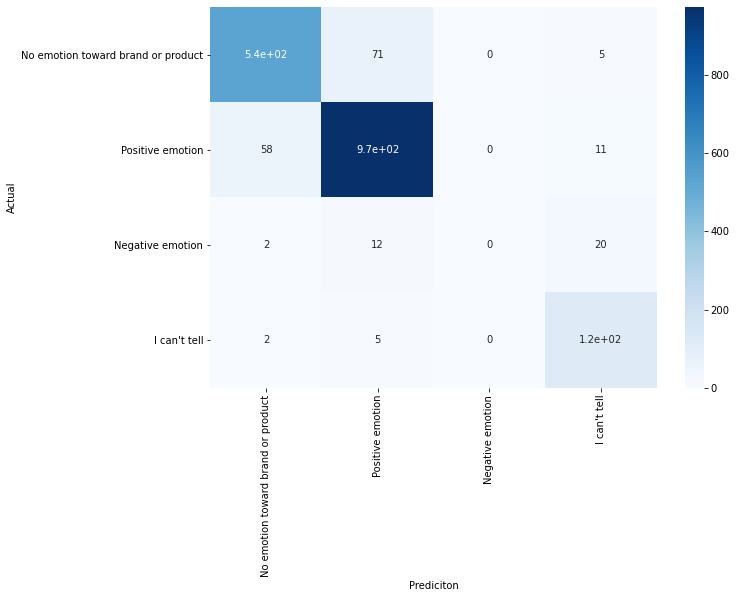

In [348]:
import seaborn as sn
import matplotlib.pyplot as plt

x_axis_labels = outcomes
y_axis_labels = outcomes

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, cmap="Blues",  xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Prediciton')
plt.ylabel('Actual')

# Results

The confusion matrix shows that there were very few tweets graded as negative.  The neural network doesn't predict any negatives due to the small number.

More than half are positive emotions, and rest is split between 'can't tell' and 'no emotion'.  

The model predicts at nearly 90% accuracy against the test set.  The base supervised modesl (untuned) only scored around 60% by comparison.  The RNN is well suited for this task.  

A larger dataset, or perhaps a more negative dataset might help train the model to make predictions at a higher rate.  In the current state, it would be unabl to pick out the negative sentiment.  Barring a larger dataset, we could oversample the minority class randomly or using SMOTE.  This would make the model more sensitive to 'negative' sentiment.
